In [0]:
import saspy
import mlflow
import mlflow.pyfunc
from mlflow.utils.environment import _mlflow_conda_env
from mlflow.models.signature import infer_signature

In [0]:
#interface for keeping SAS models in MLFlow
class SASModelInterface(mlflow.pyfunc.PythonModel):
  def __init__(self, name):
    pass
 # def fit(train_input):
 #   pass
  def predict(self, context, model_input, sas_session) -> DataFrame:
    pass

In [0]:
#Prepare a data set obtain one from our SAS Environment
sas = saspy.SASsession( cfgfile = '/databricks/sasconfig/sascfg_personal.py',
                       cfgname='ssh_sas',
                       display='databricks'
                      )
model_df = sas.sd2df(table='baseball', libref='sashelp', method = 'MEMORY') 

                    

/databricks/python/lib/python3.8/site-packages/saspy/sasiostdio.py:970: UserWarning: Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem
 warnings.warn("Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem")
SAS Connection established. Subprocess id is 1391

In [0]:
# Class Holds a Regression Model 
class SASModelSimpleRegression(SASModelInterface):
  
  def __init__(self, name,out_predict_var,in_vars):
    self.name = name
    self.in_vars = in_vars
    self.out_predict_var = out_predict_var
    
    self.model_params_dict = {}
    self.model_score_dict = {}
    
    
    self.sas = saspy.SASsession( cfgfile = '/databricks/sasconfig/sascfg_personal.py',
                       cfgname='ssh_sas',
                       display='databricks'
                      )
    
    def dbDISPLAY(x):
      displayHTML(x)
      
    self.sas.DISPLAY = dbDISPLAY
    
   
 # main method
  def predict(self, context, model_input):
    
    # upload model input into SAS Environment
    c = self.sas.submitLST("""LIBNAME test BASE "/opt/sas/sasdata";""")
    sas_tbl = self.sas.df2sd(df=model_input, table = 'model_input', libref='test')
    

    # Submit SAS Statement for a Regression Model
    c = self.sas.submitLST(""" 
             proc reg data=test.model_input outest=parmest tableout;
                  model {} = {};
                     output out=pred p=p;
            quit;
          """.format(self.out_predict_var,self.in_vars))
    # Download Model Output and Params
    model_output = self.sas.sd2df(table='pred', libref='WORK', method = 'MEMORY') 
    model_params = self.sas.sd2df(table='parmest', libref='WORK', method = 'MEMORY') 
  

    #get model params and scores
    self.getSetModelParamsAndScores(model_params)

    return model_output

  # retrieve model params and scores  
  def getSetModelParamsAndScores(self, model_params):
    
    
    # get only row with params
    param_row = model_params[model_params["_TYPE_"]=="PARMS"]
    
    display(param_row)
    # Get Column Weights 
    self.model_params_dict = param_row[param_row.columns[5:]].to_dict('records')[0]

    # GET RMSE
    self.model_score_dict = param_row[["_RMSE_"]].to_dict('records')[0]

    
    

SAS Connection terminated. Subprocess id was 1555
SAS Connection terminated. Subprocess id was 1573
/databricks/python/lib/python3.8/site-packages/saspy/sasiostdio.py:970: UserWarning: Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem
 warnings.warn("Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem")
SAS Connection established. Subprocess id is 1604

 
 proc reg data=test.model_input outest=parmest tableout;
 model logsalary = nHits nAssts nError nBB YrMajor;
 output out=pred p=p;
 quit;

21 ods listing close;ods html5 (id=saspy_internal) file=stdout options(bitmap_mode='inline') device=svg style=HTMLBlue; ods
21 ! graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: STDOUT
22 
23 LIBNAME test BASE "/opt/sas/sasdata";
NOTE: Libref TEST was successfully assigned as follows: 
 Engine: BASE 
 Physical Name: /opt/sas/sasdata
24 
25 ods html5 (id=saspy_internal) close;ods listing;

<!DOCTYPE html>
 
 
 
 
 SAS Output 

 
 
 
 
 The SAS System 
 
 
 The REG Procedure 
 Model: MODEL1 
 Dependent Variable: logSalary 
 
 
 
 
 
 
 
 
 
 
 Number of Observations Read 
 322 
 
 
 Number of Observations Used 
 263 
 
 
 Number of Observations with Missing Values 
 59 
 
 
 
 
 
 
 
 
 
 
 Analysis of Variance 
 
 
 Source 
 DF 
 Sum of Squares 
 Mean Square 
 F Value 
 Pr > F 
 
 
 
 
 Model 
 5 
 121.32555 
 24.26511 
 72.66 
 <.0001 
 
 
 Error 
 257 
 85.82818 
 0.33396 
   
   
 
 
 Corrected Total 
 262 
 207.15373 
   
   
   
 
 
 
 
 
 
 
 
 
 
 Root MSE 
 0.57789 
 R-Square 
 0.5857 
 
 
 Dependent Mean 
 5.92722 
 Adj R-Sq 
 0.5776 
 
 
 Coeff Var 
 9.74983 
   
   
 
 
 
 
 
 
 
 
 
 
 Parameter Estimates 
 
 
 Variable 
 DF 
 Parameter Estimate 
 Standard Error 
 t Value 
 Pr > |t| 
 
 
 
 
 Intercept 
 1 
 4.05729 
 0.11788 
 34.42 
 <.0001 
 
 
 nHits 
 1 
 0.00842 
 0.00105 
 8.05 
 <.0001 
 
 
 nAssts 
 1 
 -0.00012256 
 0.00035173 
 -0.35 
 0.7278 
 
 
 nError 
 1 
 -0.00684 
 0.00773 
 -0.88 
 0.3773 
 
 
 nBB 
 1 
 0.00700 
 0.00206 
 3.41 
 0.0008 
 
 
 YrMajor 
 1 
 0.09901 
 0.00764 
 12.95 
 <.0001 
 
 
 
 
 
 
 
 
 The SAS System 
 
 
 The REG Procedure 
 Model: MODEL1 
 Dependent Variable: logSalary
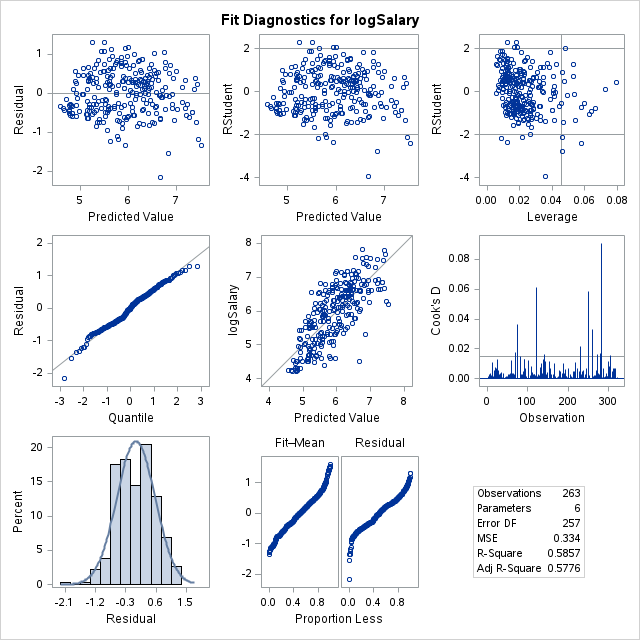
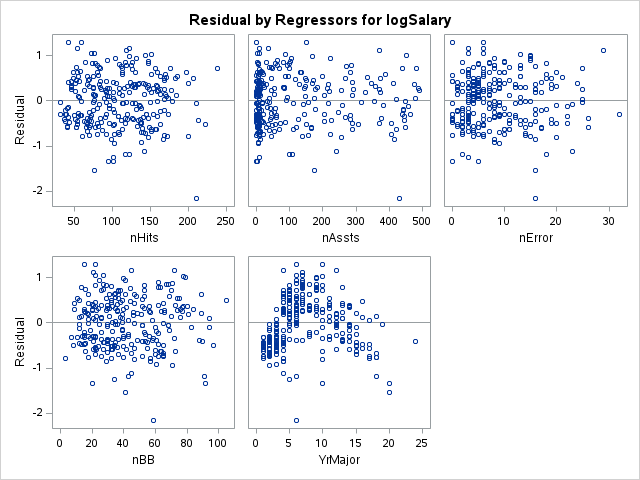

_MODEL_,_TYPE_,_DEPVAR_,_RMSE_,Intercept,nHits,nAssts,nError,nBB,YrMajor,logSalary
MODEL1,PARMS,logSalary,0.5778942755244,4.0572930913871,0.00842187934193,-1.22562357E-4,-0.00683676744274,0.00700010288832,0.09900953002302,-1.0


In [0]:
import mlflow


# Access these runs using the Experiment sidebar. Click Experiment at the upper right of this screen. 
with mlflow.start_run():
  
  
  # define a subset of columns for reg model
  #in_vars = "nHits nBB YrMajor"
  in_vars = "nHits nAssts nError nBB YrMajor"
  
  # define predict target
  out_predict_var = "logsalary"
  
  # create model
  sas_sr_model = SASModelSimpleRegression("Simple SAS Regression",in_vars=in_vars,out_predict_var=out_predict_var)
  
  
  # run model
  predictions_out = sas_sr_model.predict(context="", model_input=model_df)
  
  
  # log mlflow params
  mlflow.log_param("in_vars", in_vars)
  for k,v in sas_sr_model.model_params_dict.items():
    mlflow.log_param(k, v)
  #log metrics
  for k,v in sas_sr_model.model_score_dict.items():
    mlflow.log_metric(k, v)
  
  # @todo: add log_artifact with PNG from SAS and add log_model to store model code in MLFlow